In [1]:
!nvidia-smi

Tue Jan 21 15:50:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   28C    P8    13W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   26C    P8     6W / 250W |  10927MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs, batch_flatten
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [31]:
import glob
import cv2


def load_data(phase, cls, les = None, data = 'sm', data_dir = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed', 
              extract_name = True, image_ch = 'rgb'):
    """
    phase = 'train', 'test'
    cls: [les]  
      'n': ['neg']
      'h': ['redspot', 'angio', 'active'], 
      'd': ['ero', 'ulc', 'str'],
      'p': ['amp', 'lym', 'tum']}
    """
    lesions = dict(neg = 'negative', 
                   redspot = 'red_spot', angio = 'angioectasia', active = 'active_bleeding', 
                   ero = 'erosion', ulcer = 'ulcer', str = 'stricture', 
                   amp = 'ampulla_of_vater', lym = 'lymphoid_follicles', tum = 'small_bowel_tumor')
    classes = dict(n = 'negative', h = 'hemorrhagic', d = 'depressed', p = 'protruded')

    path = os.path.join(data_dir, data, phase, classes[cls], lesions[les])
    pathlist = glob.glob(path + '/*.jpg')
    
    new_pathlist = []
    for p in pathlist:
        name = os.path.basename(p)
        name_seg1 = name.split('___')[0]
        if not ('f_' in name_seg1 or 'r1_' in name_seg1 or 'r2_' in name_seg1 or 'r3_' in name_seg1):
            new_pathlist.append(p)
    return load_image_from_path(new_pathlist, image_ch = image_ch, extract_name = extract_name)

def load_image_from_path(pathlist,image_ch = 'bgr', extract_name = False):
    data = []
    for i in pathlist:
        temp = cv2.imread(i)
        if image_ch == 'bgr':
            pass
        elif image_ch == 'rgb':
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        elif image_ch == 'hsv':
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)
        data.append(temp)
    if extract_name != False:
        name = []
        for i in pathlist:
            name.append(os.path.basename(i))
        return np.asarray(data), np.asarray(name)
    else:
        return np.asarray(data) 

In [32]:
neg_nh_img, neg_nh_name = load_data('test', 'n', 'neg', data = 'sm_core/nh')
neg_nd_img, neg_nd_name = load_data('test', 'n', 'neg', data = 'sm_core/nd')
neg_img, neg_name = np.vstack([neg_nh_img, neg_nd_img]), np.hstack([neg_nh_name, neg_nd_name])
redspot_img, redspot_name = load_data('test', 'h', 'redspot', data = 'sm_core/nh')
angio_img, angio_name = load_data('test', 'h', 'angio', data = 'sm_core/nh')
active_img, active_name = load_data('test', 'h', 'active', data = 'sm_core/nh')
ero_img, ero_name = load_data('test', 'd', 'ero', data = 'sm_core/nd')
ulcer_img, ulcer_name = load_data('test', 'd', 'ulcer', data = 'sm_core/nd')
str_img, str_name = load_data('test', 'd', 'str', data = 'sm_core/nd')

In [33]:
neg_nh_label = one_hot(neg_nh_img, 0)
neg_nd_label = one_hot(neg_nd_img, 0)
neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("total negative:",neg_img.shape, neg_label.shape)
print("negative for nh:",neg_nh_img.shape, neg_nh_label.shape)
print("negative for nd:",neg_nd_img.shape, neg_nd_label.shape)
print('')
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

total negative: (299, 512, 512, 3) (299, 2)
negative for nh: (98, 512, 512, 3) (98, 2)
negative for nd: (201, 512, 512, 3) (201, 2)

red spot: (46, 512, 512, 3) (46, 2)
angioectasia: (3, 512, 512, 3) (3, 2)
active_bleeding: (50, 512, 512, 3) (50, 2)
erosion: (97, 512, 512, 3) (97, 2)
ulcer: (95, 512, 512, 3) (95, 2)
stricture: (10, 512, 512, 3) (10, 2)


# Model Inference

In [34]:
nh_list = sorted([i[:-5] for i in os.listdir('./model/CORE') if 'meta' in i and 'CORE_rgb_NH' in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model/CORE') if 'meta' in i and 'CORE_rgb_ND' in i])
b_list = sorted([i[:-5] for i in os.listdir('./model/CORE') if 'meta' in i and 'CORE_rgb_B' in i])

In [35]:
nh_list

['CORE_rgb_NH_2001041908_8770_val_acc_1.00_val_loss_0.000000',
 'CORE_rgb_NH_2001041909_8890_val_acc_1.00_val_loss_0.000000',
 'CORE_rgb_NH_2001041909_8960_val_acc_1.00_val_loss_0.000000',
 'CORE_rgb_NH_2001041913_9360_val_acc_1.00_val_loss_0.000000',
 'CORE_rgb_NH_2001041914_9540_val_acc_1.00_val_loss_0.000000']

In [36]:
nd_list

['CORE_rgb_ND_2001041923_8910_val_acc_1.00_val_loss_0.000802',
 'CORE_rgb_ND_2001041925_9170_val_acc_1.00_val_loss_0.000772',
 'CORE_rgb_ND_2001042207_10030_val_acc_1.00_val_loss_0.000457',
 'CORE_rgb_ND_2001042207_10040_val_acc_1.00_val_loss_0.000284',
 'CORE_rgb_ND_2001042229_12730_val_acc_1.00_val_loss_0.000018']

In [37]:
b_list

['CORE_rgb_B_2001041918_7510_val_acc_1.00_val_loss_0.004834',
 'CORE_rgb_B_2001041919_7670_val_acc_1.00_val_loss_0.001308',
 'CORE_rgb_B_2001041926_8400_val_acc_1.00_val_loss_0.000314',
 'CORE_rgb_B_2001042014_13950_val_acc_1.00_val_loss_0.000256',
 'CORE_rgb_B_2001042017_14320_val_acc_1.00_val_loss_0.000236']

In [38]:
nh_path = './model/CORE/' + nh_list[0]
nd_path = './model/CORE/' + nd_list[0]
b_path = './model/CORE/' + b_list[0]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

In [39]:
neg_nh_output = model_prob(NH_model, neg_nh_img)
neg_nd_output = model_prob(ND_model, neg_nd_img)

#: 98 / Inference Time: 00:00:00
#: 201 / Inference Time: 00:00:01


In [40]:
neg_e_output, _, _ = model_prob(E_model, neg_img, model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_img, model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_img, model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_img, model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_img, model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_img, model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_img, model_type = 'ensemble')

#: 299 / Inference Time: 00:00:02
#: 46 / Inference Time: 00:00:00
#: 3 / Inference Time: 00:00:00
#: 50 / Inference Time: 00:00:00
#: 97 / Inference Time: 00:00:01
#: 95 / Inference Time: 00:00:01
#: 10 / Inference Time: 00:00:00


In [41]:
neg_b_output = model_prob(B_model, neg_img)
redspot_b_output = model_prob(B_model, redspot_img)
angio_b_output = model_prob(B_model, angio_img)
active_b_output = model_prob(B_model, active_img)
ero_b_output = model_prob(B_model, ero_img)
ulcer_b_output = model_prob(B_model, ulcer_img)
str_b_output  = model_prob(B_model, str_img)

#: 299 / Inference Time: 00:00:01
#: 46 / Inference Time: 00:00:00
#: 3 / Inference Time: 00:00:00
#: 50 / Inference Time: 00:00:00
#: 97 / Inference Time: 00:00:00
#: 95 / Inference Time: 00:00:00
#: 10 / Inference Time: 00:00:00


# Evaluation

In [42]:
cls = classification_metric()

## Accuracy per lesion

In [43]:
neg_nh_acc = cls.accuracy(neg_nh_label, neg_nh_output)
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output)
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output)
active_nh_acc = cls.accuracy(active_label, active_nh_output)

Accuracy: 100.00 %
Accuracy: 97.83 %
Accuracy: 100.00 %
Accuracy: 100.00 %


In [44]:
neg_nd_acc = cls.accuracy(neg_nd_label, neg_nd_output)
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output)
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output)
str_nd_acc = cls.accuracy(str_label, str_nd_output)

Accuracy: 99.00 %
Accuracy: 97.94 %
Accuracy: 95.79 %
Accuracy: 100.00 %


In [45]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output)
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output)
angio_b_acc = cls.accuracy(angio_label, angio_b_output)
active_b_acc = cls.accuracy(active_label, active_b_output)
ero_b_acc = cls.accuracy(ero_label, ero_b_output)
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output)
str_b_acc = cls.accuracy(str_label, str_b_output)

Accuracy: 97.32 %
Accuracy: 100.00 %
Accuracy: 100.00 %
Accuracy: 100.00 %
Accuracy: 89.69 %
Accuracy: 85.26 %
Accuracy: 100.00 %


In [46]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output)
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output)
angio_e_acc = cls.accuracy(angio_label, angio_e_output)
active_e_acc = cls.accuracy(active_label, active_e_output)
ero_e_acc = cls.accuracy(ero_label, ero_e_output)
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output)
str_e_acc = cls.accuracy(str_label, str_e_output)

Accuracy: 97.99 %
Accuracy: 97.83 %
Accuracy: 100.00 %
Accuracy: 100.00 %
Accuracy: 98.97 %
Accuracy: 95.79 %
Accuracy: 100.00 %


## Confusion Matrix

In [47]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg_nh_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

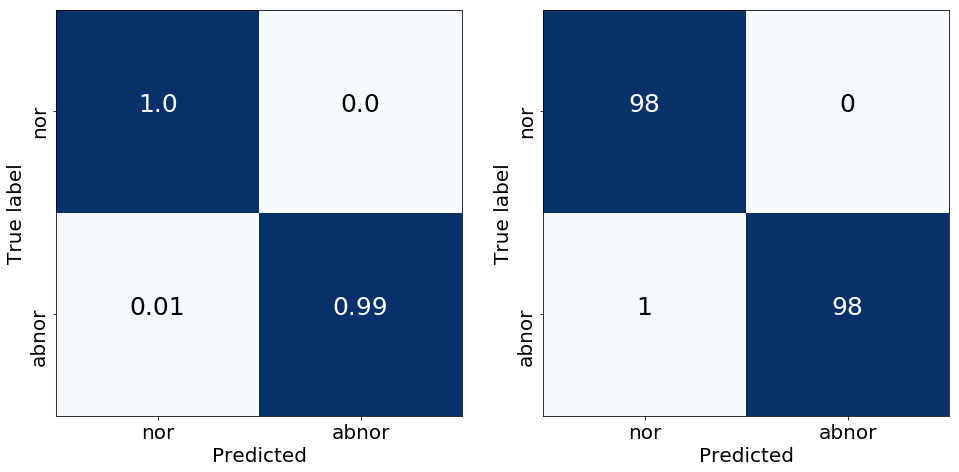

In [48]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [49]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg_nd_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

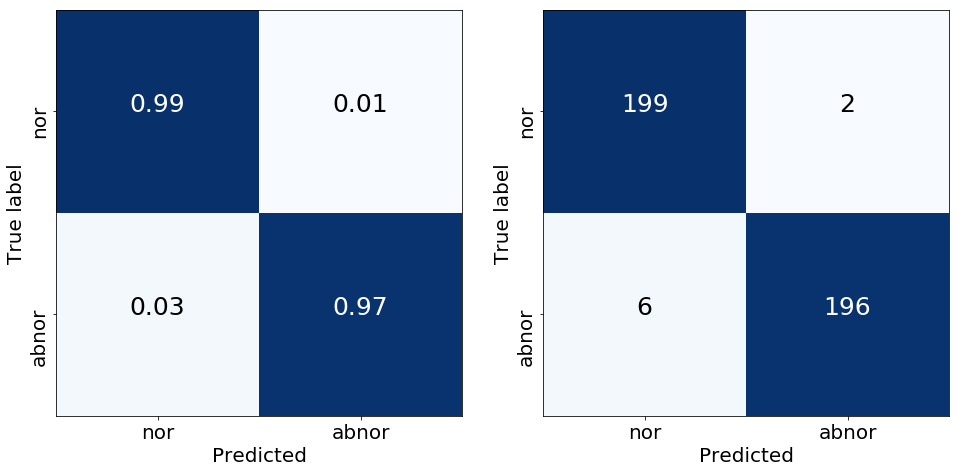

In [50]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [51]:
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

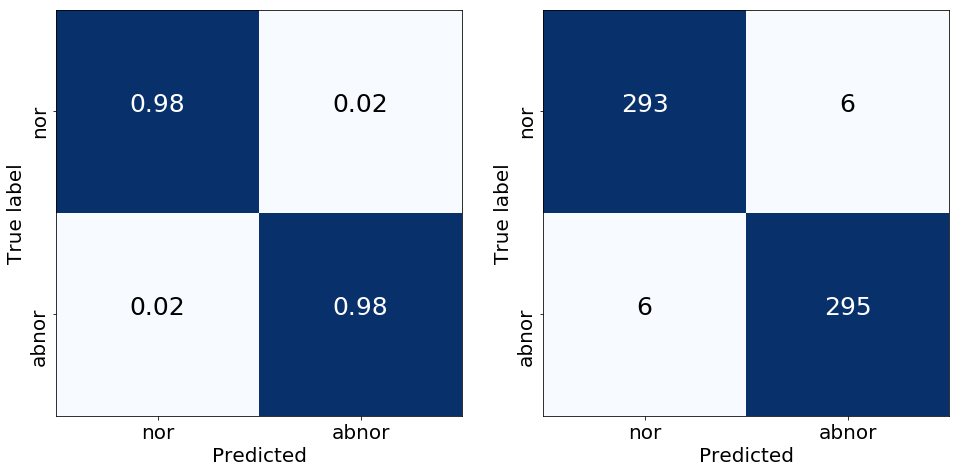

In [52]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [53]:
b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

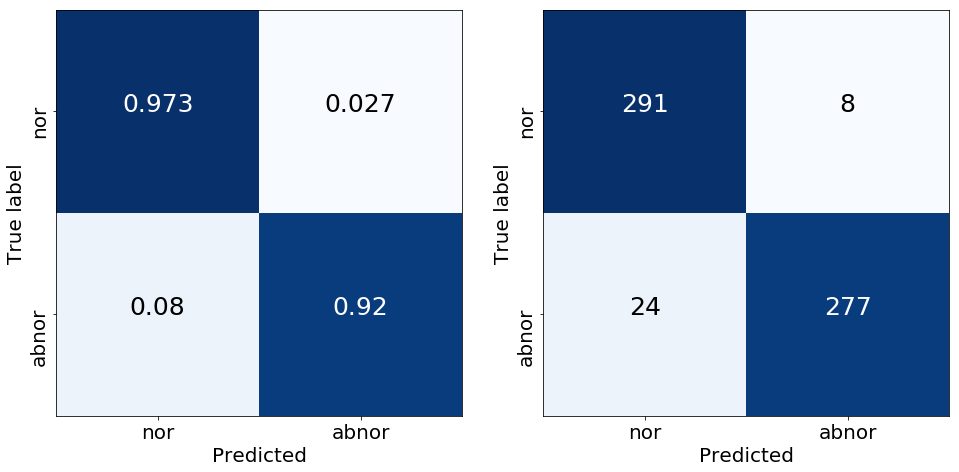

In [54]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## ROC curve

In [55]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

In [56]:
from sklearn.model_selection import KFold

In [57]:
def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [58]:
n_g = 10

_, neg_nh_idxs = k_fold_idx(n_fold = n_g, dataset = neg_nh_label)
_, neg_nd_idxs = k_fold_idx(n_fold = n_g, dataset = neg_nd_label)
_, neg_idxs = k_fold_idx(n_fold = n_g, dataset = neg_label)
_, redspot_idxs = k_fold_idx(n_fold = n_g, dataset = redspot_label)
_, angio_idxs = k_fold_idx(n_fold = n_g, dataset = angio_label)
_, active_idxs = k_fold_idx(n_fold = n_g, dataset = active_label)
_, ero_idxs = k_fold_idx(n_fold = n_g, dataset = ero_label)
_, ulcer_idxs = k_fold_idx(n_fold = n_g, dataset = ulcer_label)
_, str_idxs = k_fold_idx(n_fold = n_g, dataset = str_label)

ValueError: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=3.

In [177]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

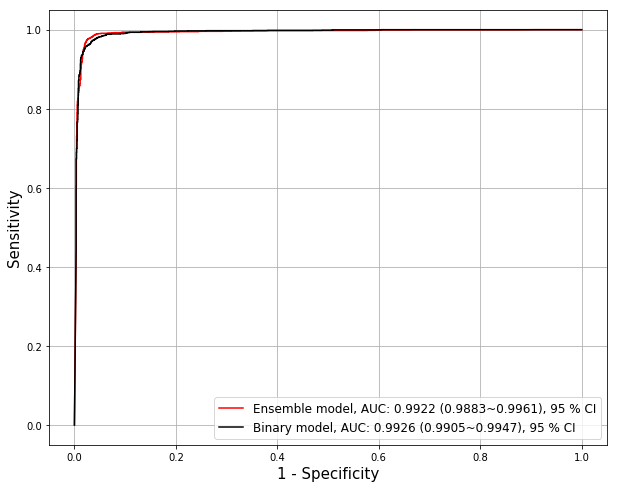

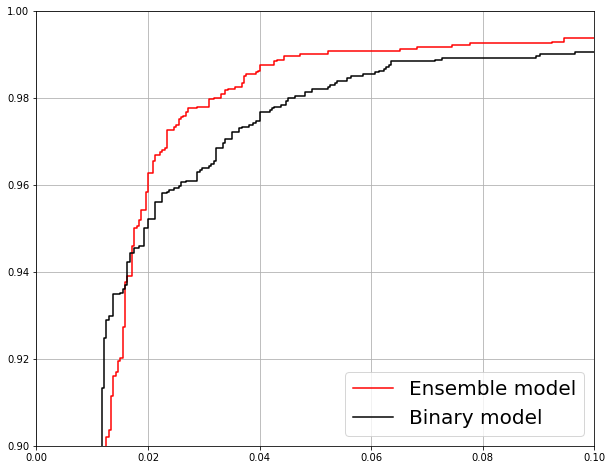

In [178]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [179]:
e_CM, b_CM = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    print(labels.shape)
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

(482, 2)
(482, 2)
(481, 2)
(481, 2)
(480, 2)
(480, 2)
(479, 2)
(479, 2)
(478, 2)
(478, 2)


In [180]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [181]:
b_metrices

array([[0.96680498, 0.95867769, 0.975     , 0.95901639, 0.97478992],
       [0.96887967, 0.97107438, 0.96666667, 0.9707113 , 0.96707819],
       [0.95841996, 0.96280992, 0.9539749 , 0.96202532, 0.95491803],
       [0.96465696, 0.94628099, 0.9832636 , 0.94758065, 0.98283262],
       [0.9625    , 0.9626556 , 0.9623431 , 0.9623431 , 0.9626556 ],
       [0.96458333, 0.95850622, 0.9707113 , 0.95867769, 0.97058824],
       [0.97912317, 0.99166667, 0.9665272 , 0.99141631, 0.96747967],
       [0.97077244, 0.96666667, 0.9748954 , 0.96680498, 0.97478992],
       [0.9665272 , 0.9707113 , 0.9623431 , 0.97046414, 0.9626556 ],
       [0.9623431 , 0.9539749 , 0.9707113 , 0.95473251, 0.97021277]])

In [182]:
e_metrices

array([[0.97925311, 0.98760331, 0.97083333, 0.98728814, 0.97154472],
       [0.98755187, 0.98347107, 0.99166667, 0.98347107, 0.99166667],
       [0.96465696, 0.96280992, 0.9665272 , 0.9625    , 0.96680498],
       [0.97713098, 0.98347107, 0.9707113 , 0.98305085, 0.97142857],
       [0.96666667, 0.97510373, 0.958159  , 0.97446809, 0.95918367],
       [0.975     , 0.97925311, 0.9707113 , 0.97890295, 0.97119342],
       [0.98329854, 0.9875    , 0.9790795 , 0.98734177, 0.97933884],
       [0.96659708, 0.96666667, 0.9665272 , 0.9665272 , 0.96666667],
       [0.9748954 , 0.9707113 , 0.9790795 , 0.97095436, 0.97890295],
       [0.97698745, 0.9790795 , 0.9748954 , 0.9789916 , 0.975     ]])

In [183]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 96.65 (96.24 ~ 97.05)
Sen --- 96.43 (95.56 ~ 97.30)
Spec --- 96.86 (96.28 ~ 97.45)
NPV --- 96.44 (95.59 ~ 97.28)
PPV --- 96.88 (96.32 ~ 97.44)

Ensemble model
Accr --- 97.52 (96.99 ~ 98.05)
Sen --- 97.76 (97.14 ~ 98.37)
Spec --- 97.28 (96.63 ~ 97.93)
NPV --- 97.73 (97.12 ~ 98.35)
PPV --- 97.32 (96.68 ~ 97.95)


### Equal-Variance Test

In [185]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 0.631, pvalue=0.426936350622
bartlett test for sensitivity: 1.037, pvalue=0.308587128180
bartlett test for specificity: 0.092, pvalue=0.761144327532
bartlett test for negative predictive values: 0.874, pvalue=0.349730662239
bartlett test for positive predictive values: 0.136, pvalue=0.711904191579


In [187]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 0.776, pvalue=0.389959094408
levene test for sensitivity: 0.247, pvalue=0.625415684856
levene test for specificity: 0.000, pvalue=0.994166146076
levene test for negative predictive values: 0.164, pvalue=0.689855809483
levene test for positive predictive values: 0.012, pvalue=0.913759020041


### Normality Test

In [188]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.600, pvalue=0.052447552448
Kolmogorov-Smirnov test for sensitivity: 0.600, pvalue=0.052447552448
Kolmogorov-Smirnov test for specificity: 0.200, pvalue=0.994457554829
Kolmogorov-Smirnov test for negative predictive values: 0.700, pvalue=0.012340600576
Kolmogorov-Smirnov test for positive predictive values: 0.400, pvalue=0.417523652818


### Wilcoxon signed-ranks test (not normal and paired group)

In [190]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 2.500, pvalue=0.010775621103
wilcoxon signed-ranks test for sensitivity: 1.000, pvalue=0.027991815486
wilcoxon signed-ranks test for specificity: 13.000, pvalue=0.259555406787
wilcoxon signed-ranks test for negative predictive values: 5.000, pvalue=0.021824275626
wilcoxon signed-ranks test for positive predictive values: 16.000, pvalue=0.241121368277


### Paired two-sample t-Test (normal and paired group)

In [191]:
from scipy.stats import ttest_rel

In [192]:
accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: -4.261, pvalue=0.002109534733
t-statistics for sensitivity: -2.928, pvalue=0.016809647112
t-statistics for specificity: -1.088, pvalue=0.304932685275
t-statistics for negative predictive values: -2.986, pvalue=0.015310824701
t-statistics for positive predictive values: -1.197, pvalue=0.261883020117


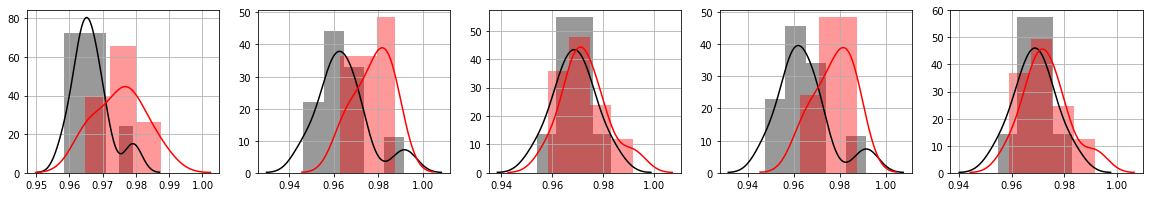

In [193]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()